In [1]:
#describe each location with companies in side
import pandas as pd
import numpy as np
import os
import pygeohash as pgh
from math import *
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression as LR
pjoin = os.path.join


In [6]:
#data load
datapath = '/Users/yefeichen/Database/location_recommender_system/'
cfile = ['dnb_pa.csv','dnb_sf.csv','dnb_sj.csv']
lfile = 'location_scorecard_190912.csv'
clfile = ['PA.csv','SF.csv','SJ.csv']
lfile_app = ['PA_comp_loc_score.csv','SF_comp_loc_score.csv','SJ_comp_loc_score.csv']
testfile = 'train_val_test_location_company_all.csv'

ind_city = 2

comp_feat = pd.read_csv('company_feat.csv',index_col=0)
loc_feat = pd.read_csv('location_feat.csv',index_col=0)
all_pair = pd.read_csv(testfile,index_col=0)
all_pair = all_pair[all_pair['city']==ind_city]

ensemble_feat = pd.read_csv(lfile_app[ind_city])

all_pair_test = all_pair[all_pair['fold']==2].reset_index(drop=True)
dat1 = all_pair[all_pair['fold']==0]

all_company_loc = pd.read_csv(pjoin(datapath,clfile[ind_city]))[['atlas_location_uuid','duns_number']]

print('Done')

Done


In [4]:
all_pair = pd.read_csv(testfile,index_col=0)

19840821

In [7]:
loc_name = all_company_loc[['atlas_location_uuid']].groupby('atlas_location_uuid')[['atlas_location_uuid']].first().reset_index(drop=True)
num_loc = len(loc_name)
print(num_loc)
# del all_company_loc

dat2 = dat1.sample(frac=1).reset_index(drop=True)
twin_dat = dat1.join(dat2, how='left', lsuffix='_left', rsuffix = '_right').reset_index(drop=True)

twin_dat = twin_dat[twin_dat['atlas_location_uuid_left'] != twin_dat['atlas_location_uuid_right']]
neg_dat1 = twin_dat[['duns_number_left', 'atlas_location_uuid_right']].reset_index(drop=True)
neg_dat1 = neg_dat1.rename(
                columns={'duns_number_left': 'duns_number', 'atlas_location_uuid_right': 'atlas_location_uuid',
                         'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                        'city_left':'city'})
neg_dat1 = neg_dat1[['duns_number','atlas_location_uuid']]
neg_dat1['label'] = 0

print(neg_dat1.columns)

neg_dat2 = twin_dat[['duns_number_right', 'atlas_location_uuid_left']].reset_index(drop=True)
neg_dat2 = neg_dat2.rename(
                columns={'duns_number_right': 'duns_number', 'atlas_location_uuid_left': 'atlas_location_uuid',
                        'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                        'city_left':'city'})
neg_dat2 = neg_dat2[['duns_number','atlas_location_uuid']]
neg_dat2['label'] = 0

pos_dat = dat1[['duns_number', 'atlas_location_uuid', 'label']]
# del dat1,dat2

train_dat = pd.concat([pos_dat, neg_dat1,neg_dat2], axis=0)
train_dat = train_dat.sample(frac=1).reset_index(drop=True)
print('Done')

614
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


In [8]:
trX = train_dat.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
trX = trX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
trX = trX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
trY = trX[['label']].to_numpy()
trX = trX[list_col].to_numpy()

ttX = all_pair_test[['duns_number','atlas_location_uuid']].merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
ttX = ttX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
ttX = ttX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
ttX = ttX[list_col].to_numpy()
ttY = (all_pair_test['atlas_location_uuid'] == all_pair_test['groundtruth']).to_numpy() + 0
# del all_pair_test

# trX[:,-1] = 0
# ttX[:,-1] = 0

trX = normalize(trX,axis=1)
ttX = normalize(ttX,axis=1)

# clf = LR(random_state=0,fit_intercept=True,
#          solver = 'lbfgs',class_weight='balanced',
#          multi_class='ovr',max_iter=1e10).fit(trX,trY)
clf = LR(random_state=0,fit_intercept=True,
         solver = 'lbfgs',
         multi_class='ovr',max_iter=1e10).fit(trX,trY)

score_ttY = clf.predict_proba(ttX)[:,1]


fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
roc_auc = auc(fpr,tpr)
print(roc_auc)
print('Done')

/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7086077239230401
Done


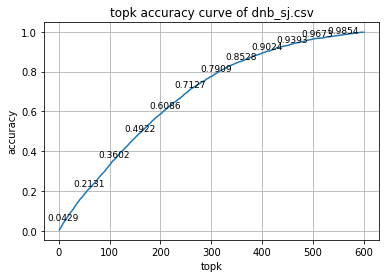

In [13]:
score_ttY = score_ttY.reshape(-1,num_loc)
# groundtruth = all_pair_test[['duns_number','groundtruth']].groupby(['duns_number','groundtruth'])[['groundtruth']].first().reset_index(drop=True).to_numpy()
# R_cat = loc_name.to_numpy().reshape(-1)
# topk_precision = calc_topk_acc_cat_all(score_ttY,groundtruth,R_cat,k=100)
ttY = ttY.reshape(-1,num_loc)
truth_cat = one_hot_2_idx_numpy(ttY)
R_cat = np.array(list(range(num_loc)))

topk = 600
step = 50
topk_precision = calc_topk_acc_cat_all(score_ttY,truth_cat,R_cat,k=topk)



x = list(range(1,topk+1))
y = list(topk_precision)
plt.figure()
plt.plot(x,y)

plt.grid()

for z in range(10,topk+1,step):
    z = z - 1
    plt.text(z, y[z], '%.4f' % y[z], ha='center', va= 'bottom',fontsize=9)

plt.xlabel("topk")
plt.ylabel("accuracy")
plt.title("topk accuracy curve of %s"%cfile[ind_city])
plt.show()


In [10]:
def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res

def one_hot_2_idx(y_one_hot):
    """
    y_one_hot:FloatTensor shape:[batch_size, nCls]
    y_idx: LongTensor shape:[batch_size,1]
    """
    _,idx_mat = torch.max(y_one_hot,1,keepdim=False)
    y_idx = idx_mat.view(-1,1)
    return y_idx

def one_hot_2_idx_numpy(y_one_hot):
    """
    y_one_hot:FloatTensor shape:[batch_size, nCls]
    y_idx: LongTensor shape:[batch_size,1]
    """
    idx_mat = np.argmax(y_one_hot,1)
    y_idx = idx_mat.reshape(-1,1)
    return y_idx

In [8]:
best_auc = 0
for lp in range(10):
    loc_name = all_company_loc[['atlas_location_uuid']].groupby('atlas_location_uuid')[['atlas_location_uuid']].first().reset_index(drop=True)
    num_loc = len(loc_name)
    print(num_loc)
    # del all_company_loc

    dat2 = dat1.sample(frac=1).reset_index(drop=True)
    twin_dat = dat1.join(dat2, how='left', lsuffix='_left', rsuffix = '_right').reset_index(drop=True)

    twin_dat = twin_dat[twin_dat['atlas_location_uuid_left'] != twin_dat['atlas_location_uuid_right']]
    neg_dat1 = twin_dat[['duns_number_left', 'atlas_location_uuid_right']].reset_index(drop=True)
    neg_dat1 = neg_dat1.rename(
                    columns={'duns_number_left': 'duns_number', 'atlas_location_uuid_right': 'atlas_location_uuid',
                             'label_left':'label','fold_left':'fold','groundtruth_left':'groundtruth',
                            'city_left':'city'})
    neg_dat1 = neg_dat1[['duns_number','atlas_location_uuid']]
    neg_dat1['label'] = 0

    print(neg_dat1.columns)

    # neg_dat2 = twin_dat[['duns_number_right', 'atlas_location_uuid_left']].reset_index(drop=True)
    # neg_dat2 = neg_dat2.rename(
    #                 columns={'duns_number_right': 'duns_number', 'atlas_location_uuid_left': 'atlas_location_uuid'})
    # neg_dat2 = neg_dat2[['duns_number','atlas_location_uuid']]
    # neg_dat2['label'] = 0

    pos_dat = dat1[['duns_number', 'atlas_location_uuid', 'label']]
    # del dat1,dat2

    train_dat = pd.concat([pos_dat, neg_dat1], axis=0)
    train_dat = train_dat.sample(frac=1).reset_index(drop=True)
    print('Done')
    trX = train_dat.merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
    trX = trX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
    trX = trX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
    list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
    list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
    trY = trX[['label']].to_numpy()
#     trX['sim_score'] = 0
    trX = trX[list_col].to_numpy()

    ttX = all_pair_test[['duns_number','atlas_location_uuid']].merge(comp_feat,on='duns_number',how='left',suffixes=['','_right']).reset_index(drop=True)
    ttX = ttX.merge(loc_feat,on='atlas_location_uuid',how='left',suffixes=['','_right']).reset_index(drop=True)
    ttX = ttX.merge(ensemble_feat,on=['atlas_location_uuid','duns_number'],how='left',suffixes=['','_right']).reset_index(drop=True)
    list_col = list(comp_feat.columns)+list(loc_feat.columns)+list(ensemble_feat.columns)
    list_col = [col for col in list_col if col not in ['duns_number', 'atlas_location_uuid', 'label']]
#     ttX['sim_score'] = 0
    ttX = ttX[list_col].to_numpy()
    ttY = (all_pair_test['atlas_location_uuid'] == all_pair_test['groundtruth']).to_numpy() + 0
    # del all_pair_test

    clf = LR(random_state=0,fit_intercept=True,
             solver = 'lbfgs',class_weight='balanced',
             multi_class='ovr',max_iter=1e10).fit(trX,trY)

    score_ttY = clf.predict_proba(ttX)[:,1]


    fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    print('Done')
    if roc_auc > best_auc:
        best_clf = clf
    

352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.552907933401182
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.544006404843891
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5410039662793719
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5549706039820648
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.564710760052904
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5564641960305777
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5418813043514504
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5466248638291163
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5315319618760701
Done
352
Index(['duns_number', 'atlas_location_uuid', 'label'], dtype='object')
Done


/Users/yefeichen/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5171374166615634
Done


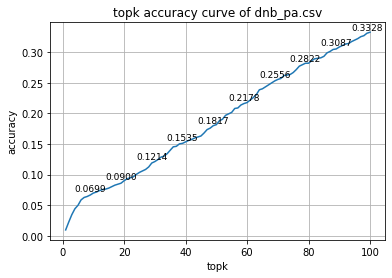

In [9]:
score_ttY = best_clf.predict_proba(ttX)[:,1]


fpr, tpr, roc_thresholds = roc_curve(ttY, score_ttY)
roc_auc = auc(fpr,tpr)

score_ttY = score_ttY.reshape(-1,num_loc)
# groundtruth = all_pair_test[['duns_number','groundtruth']].groupby(['duns_number','groundtruth'])[['groundtruth']].first().reset_index(drop=True).to_numpy()
# R_cat = loc_name.to_numpy().reshape(-1)
# topk_precision = calc_topk_acc_cat_all(score_ttY,groundtruth,R_cat,k=100)
ttY = ttY.reshape(-1,num_loc)
truth_cat = one_hot_2_idx_numpy(ttY)
R_cat = np.array(list(range(num_loc)))

topk = 100
topk_precision = calc_topk_acc_cat_all(score_ttY,truth_cat,R_cat,k=topk)



x = list(range(1,topk+1))
y = list(topk_precision)
plt.figure()
plt.plot(x,y)

plt.grid()

for z in range(10,topk+1,10):
    z = z - 1
    plt.text(z, y[z], '%.4f' % y[z], ha='center', va= 'bottom',fontsize=9)

plt.xlabel("topk")
plt.ylabel("accuracy")
plt.title("topk accuracy curve of %s"%cfile[ind_city])
plt.show()


In [17]:
print(list_col)

['emp_here', 'emp_total', 'sales_volume_us', 'square_footage', 'emp_here_range', 'major_industry_category_AGRICULTURE/FORESTRY/FISHING', 'major_industry_category_CONSTRUCTION', 'major_industry_category_FIN/INSURANCE/REAL ESTATE', 'major_industry_category_MANUFACTURING', 'major_industry_category_MINING', 'major_industry_category_MISC/PUBLIC ADMINISTRATION', 'major_industry_category_RETAIL TRADE', 'major_industry_category_SERVICES', 'major_industry_category_TRANS/COMMUNICATIONS/UTILITIES', 'major_industry_category_WHOLESALE TRADE', 'major_industry_category_nan', 'location_type_BRANCH', 'location_type_HEADQUARTERS', 'location_type_SINGLE', 'location_type_nan', 'primary_sic_2_digit_1', 'primary_sic_2_digit_10', 'primary_sic_2_digit_12', 'primary_sic_2_digit_13', 'primary_sic_2_digit_14', 'primary_sic_2_digit_15', 'primary_sic_2_digit_16', 'primary_sic_2_digit_17', 'primary_sic_2_digit_2', 'primary_sic_2_digit_20', 'primary_sic_2_digit_21', 'primary_sic_2_digit_22', 'primary_sic_2_digit_23'

array([-0.10165502, -0.0209487 , -0.01242485, -0.11697559, -0.21866524,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [39]:
x = np.random.random((3,5))
y = normalize(x,axis=1)

In [43]:
(y**2).sum(axis=1)

array([1., 1., 1.])